## Alanine Dipeptide

In this example, we use the Nutmeg models to simulate alanine dipeptide.  We create a Ramachandran plot for each model to see how the results compare to each other.  We also run a simulation with a conventional force field as another comparison.  We run the simulations with OpenMM, analyze the angles with MDTraj, and plot the results with matplotlib.

Let's start by importing all the libraries we will be using.

In [1]:
from openmm import *
from openmm.app import *
from openmm.unit import *
from openmmml import *
import nutmegpotentials
import numpy as np
import mdtraj
import matplotlib.pyplot as plot
from sys import stdout

Next we load a PDB file for the model we want to simulate.  It contains a single alanine dipeptide in a box of water.

In [2]:
pdb = PDBFile('alanine-dipeptide.pdb')

Since we will be running several simulations, let's define a function for running them.  It energy minimizes the system, then simulates it for 1 ns (1 million steps), saving a frame every 1 ps.  1 ns is a fairly short time to fully map out the distribution.  To keep the simulations short, we use an elevated temperature (450K) to speed up transitions and accelerate convergence.  For real work you would probably want to instead run the simulations longer, or perhaps use an accelerated sampling method like simulated tempering or metadynamics.

In [3]:
def simulate(system, name):
    integrator = LangevinMiddleIntegrator(450*kelvin, 1.0/picosecond, 0.001*picosecond)
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(pdb.positions/nanometers)
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(450*kelvin)
    simulation.reporters.append(DCDReporter(f'{name}.dcd', 1000))
    simulation.step(1000000)

First we will simulate it with the conventional Amber ff14 force field and TIP3P-FB water model.  On any reasonable GPU, this should only take a few minutes at most.

In [4]:
ff = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
mm_system = ff.createSystem(pdb.topology)
simulate(mm_system, 'amber')

Next we simulate it with each of the three Nutmeg models.  We create a mixed system, using the Nutmeg model to compute the internal energy of the alanine dipeptide, and the conventional force field for the water and for the interactions between the water and peptide.  On a good GPU, this takes a few hours for each model.

In [5]:
atoms = [atom.index for atom in pdb.topology.atoms() if atom.residue.chain.index == 0]
for model in ['nutmeg-small', 'nutmeg-medium', 'nutmeg-large']:
    print('Simulating', model)
    potential = MLPotential(model)
    mixed_system = potential.createMixedSystem(pdb.topology, mm_system, atoms, total_charge=0)
    simulate(mixed_system, model)

Simulating nutmeg-small


Simulating nutmeg-medium
Simulating nutmeg-large


This function uses MDTraj to compute the $\phi$ and $\psi$ angles, then plots a histogram of them with matplotlib.

In [6]:
def ramachandran(name):
    traj = mdtraj.load(f'{name}.dcd', top='alanine-dipeptide.pdb')
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    angles = mdtraj.compute_dihedrals(traj, [phi_indices, psi_indices])
    plot.hist2d(angles[:, 0], angles[:, 1], bins=30, range=[[-np.pi, np.pi], [-np.pi, np.pi]])
    plot.xlabel('$\phi$')
    plot.ylabel('$\psi$')
    plot.title(name)

Now we can create the plots for the four models.

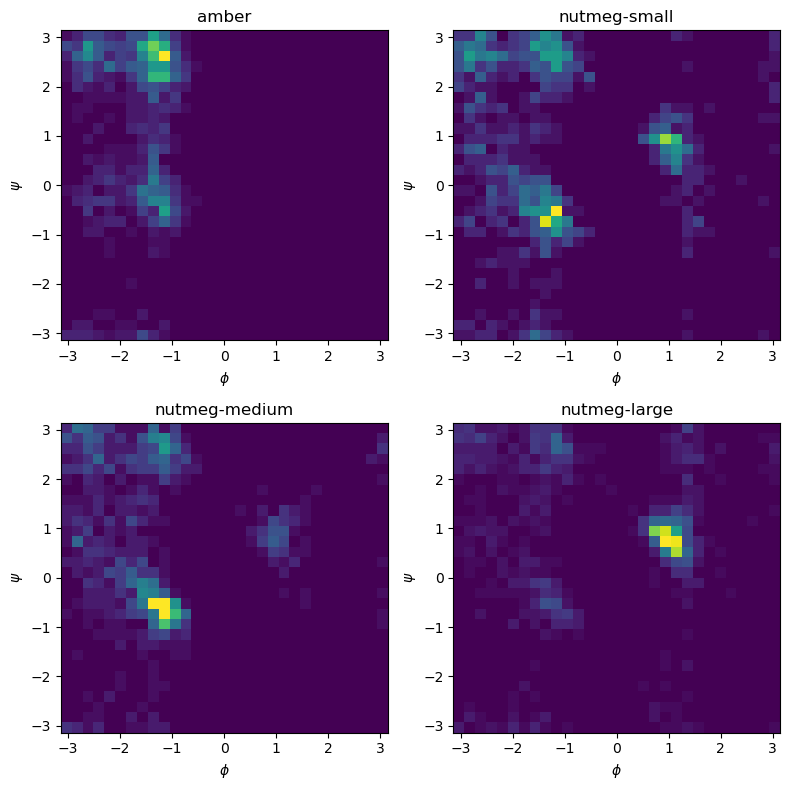

In [7]:
plot.figure(figsize=(8, 8))
for i, name in enumerate(['amber', 'nutmeg-small', 'nutmeg-medium', 'nutmeg-large']):
    plot.subplot(2, 2, i+1)
    ramachandran(name)
plot.tight_layout()
plot.show()

The variations in how much time was spent in each region probably just represent incomplete equilibration.  The more significant difference is that all of the Nutmeg models managed to explore all major regions, whereas the Amber simulation never reached the $L\alpha$ region corresponding to a left handed helix.

![Ramachandran](https://upload.wikimedia.org/wikipedia/commons/8/85/Ramachandran_plot_original_outlines.jpg)

(Image from Wikimedia Commons.)